# Notes 2 - Predictors of recorded DS live births

Next:

- Review data to see if we can go back further - check race
- Hyperparameter tuning
- Consider bagging vs GOSS


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = repl_utils.RANDOM_SEED
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0002-predictors/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-22T18:28:37.396645
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
cores: 32
physical_cores: 24
ram: 127 GB
ram_available: 104 GB
cuda: True
cuda_device_count: 1
cuda_device_0: NVIDIA GeForce RTX 4070 Ti SUPER
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0002-predictors/20251222-182837
--------------------



### Options


In [ ]:
START_YEAR = 2005
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 5000  # 10000
EARLY_STOPPING_ROUNDS = 10
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = False
#
OPTIMIZE_TRIALS = 40

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(from_year=START_YEAR)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

### Split training, validation and calibration data


In [5]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [6]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 39061040 negatives, 19869 positives, probability positive 0.00050867
Validation set: 19530520 negatives, 9934 positives, probability positive 0.00050864
Calibration set: 19530521 negatives, 9934 positives, probability positive 0.00050864


In [7]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {
    "learning_rate": 0.014891637649695044,
    "num_leaves": 81,
    "min_data_in_leaf": 864,
    "min_gain_to_split": 0.3567776136266129,
    "feature_fraction": 0.610222833973872,
    "bagging_fraction": 0.9226890884051586,
    "bagging_freq": 6,
    "lambda_l1": 0.00021596947276958148,
    "lambda_l2": 8.98208844422193,
}

## Hyperparameter tuning


In [8]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 202512
  "num_threads": 24
  "verbosity": 1
  "learning_rate": 0.014891637649695044
  "num_leaves": 81
  "min_data_in_leaf": 864
  "min_gain_to_split": 0.3567776136266129
  "feature_fraction": 0.610222833973872
  "bagging_fraction": 0.9226890884051586
  "bagging_freq": 6
  "lambda_l1": 0.00021596947276958148
  "lambda_l2": 8.98208844422193
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [9]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 1191
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	train's average_precision: 0.519986	train's binary_logloss: 0.00266056	valid's average_precision: 0.5135	valid's binary_logloss: 0.00267797
[20]	train's average_precision: 0.537466	train's binary_logloss: 0.00252096	valid's average_precision: 0.531511	valid's binary_logloss: 0.00254193
[30]	train's average_precision: 0.539067	train's binary_logloss: 0.00240878	valid's average_precision: 0.53285	valid's binary_logloss: 0.00243273
[40]	train's average_precision: 0.540153	train's binary_logloss: 0.00233959	valid's average_precision: 0.533761	valid's binary_logloss: 0.002366
[50]	train's avera

In [10]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [11]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.966440
1,Validation AP,0.553054
2,Validation log loss,0.001847
3,Precision at 10000,0.528900
4,Recall at 10000,0.532414
5,Precision (threshold=0.01),0.118651
6,Recall (threshold=0.01),0.622710


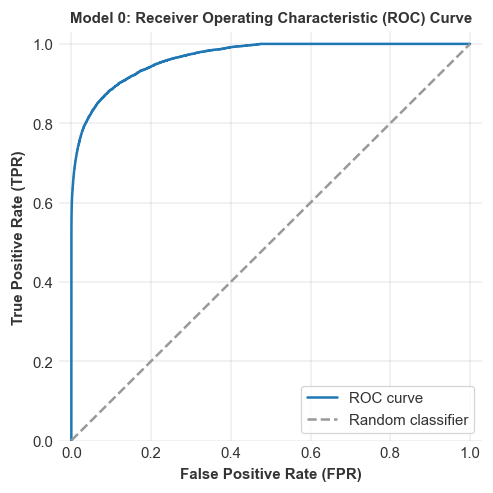

In [12]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

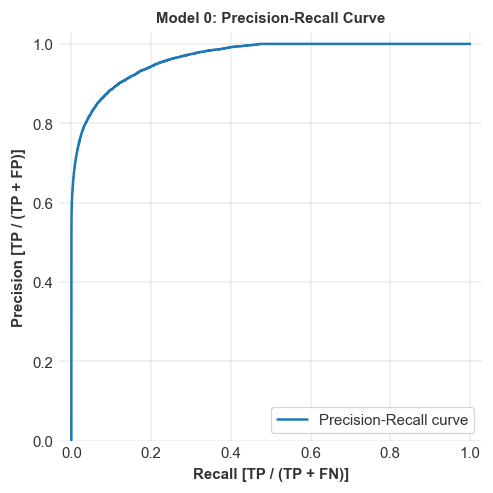

In [13]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [14]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
41,no_congen,2.995909e+06
32,ca_cchd,5.193698e+05
37,ca_cleft,3.901726e+05
39,ca_hypo,3.376631e+05
35,ca_gast,2.928487e+05
53,mage_c,2.832748e+05
40,ca_disor,2.779223e+05
31,ca_mnsb,1.988984e+05
25,ab_nicu,1.883780e+05
30,ca_anen,1.627251e+05


### Evaluation subset for permutation importances and SHAP analysis


In [15]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [16]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=5,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
41,no_congen,4.995925e-01,1.240686e-03
32,ca_cchd,2.085304e-01,1.676979e-03
37,ca_cleft,1.706134e-01,1.634656e-03
40,ca_disor,1.654304e-01,1.398774e-03
39,ca_hypo,1.461282e-01,2.204427e-03
31,ca_mnsb,1.157868e-01,1.569877e-03
34,ca_omph,9.145449e-02,9.222246e-04
30,ca_anen,8.750964e-02,1.172728e-03
35,ca_gast,8.116224e-02,1.112619e-03
38,ca_clpal,7.849124e-02,5.331707e-04


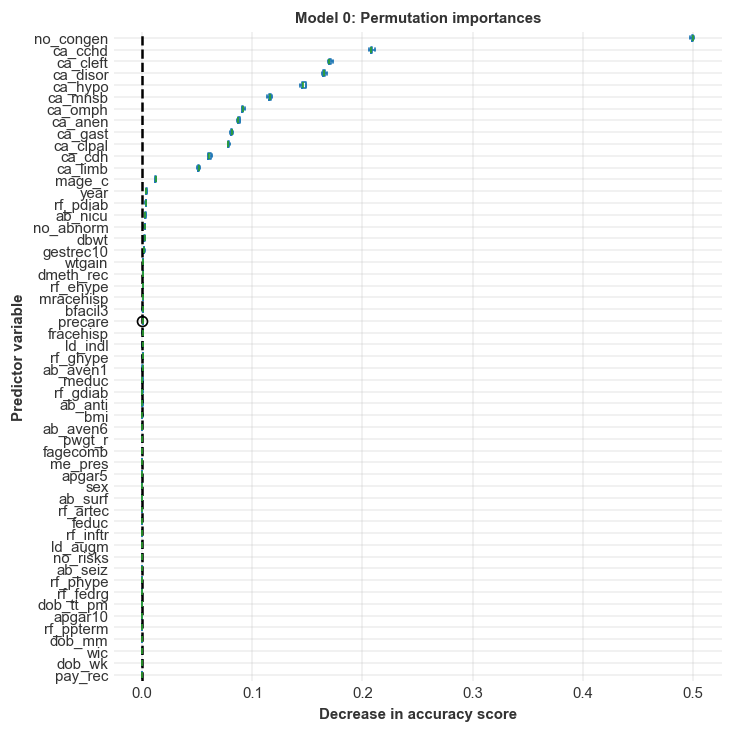

In [18]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

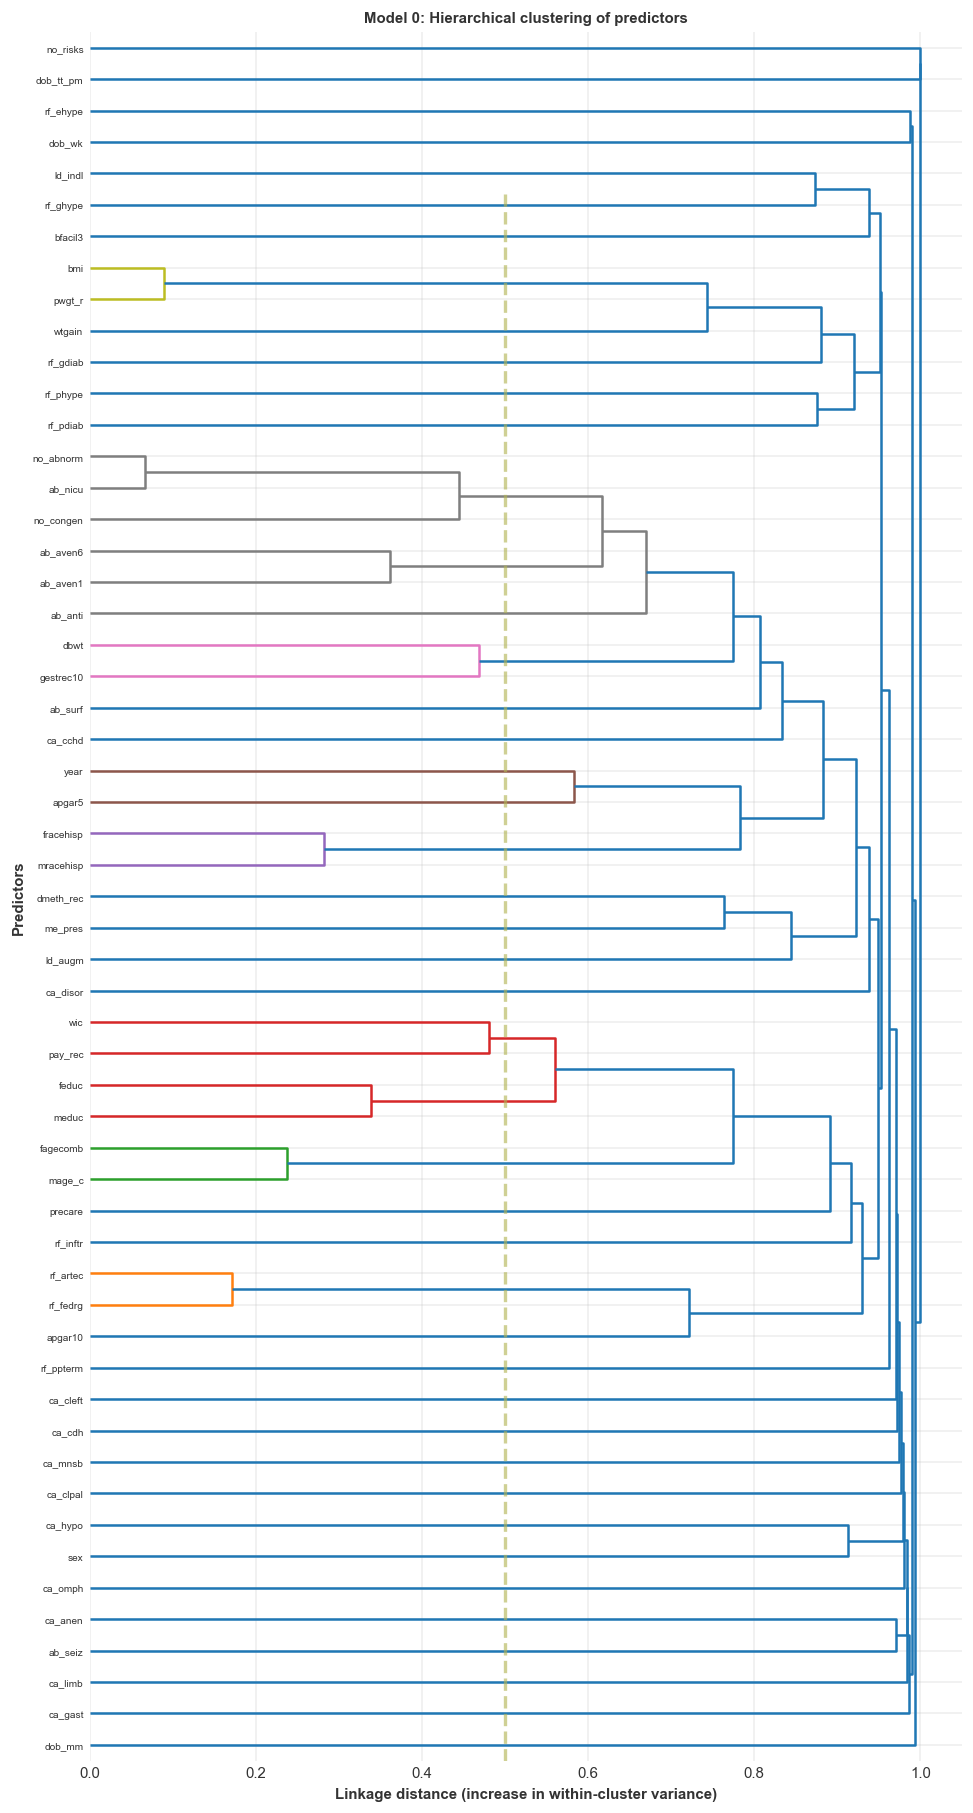

In [19]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

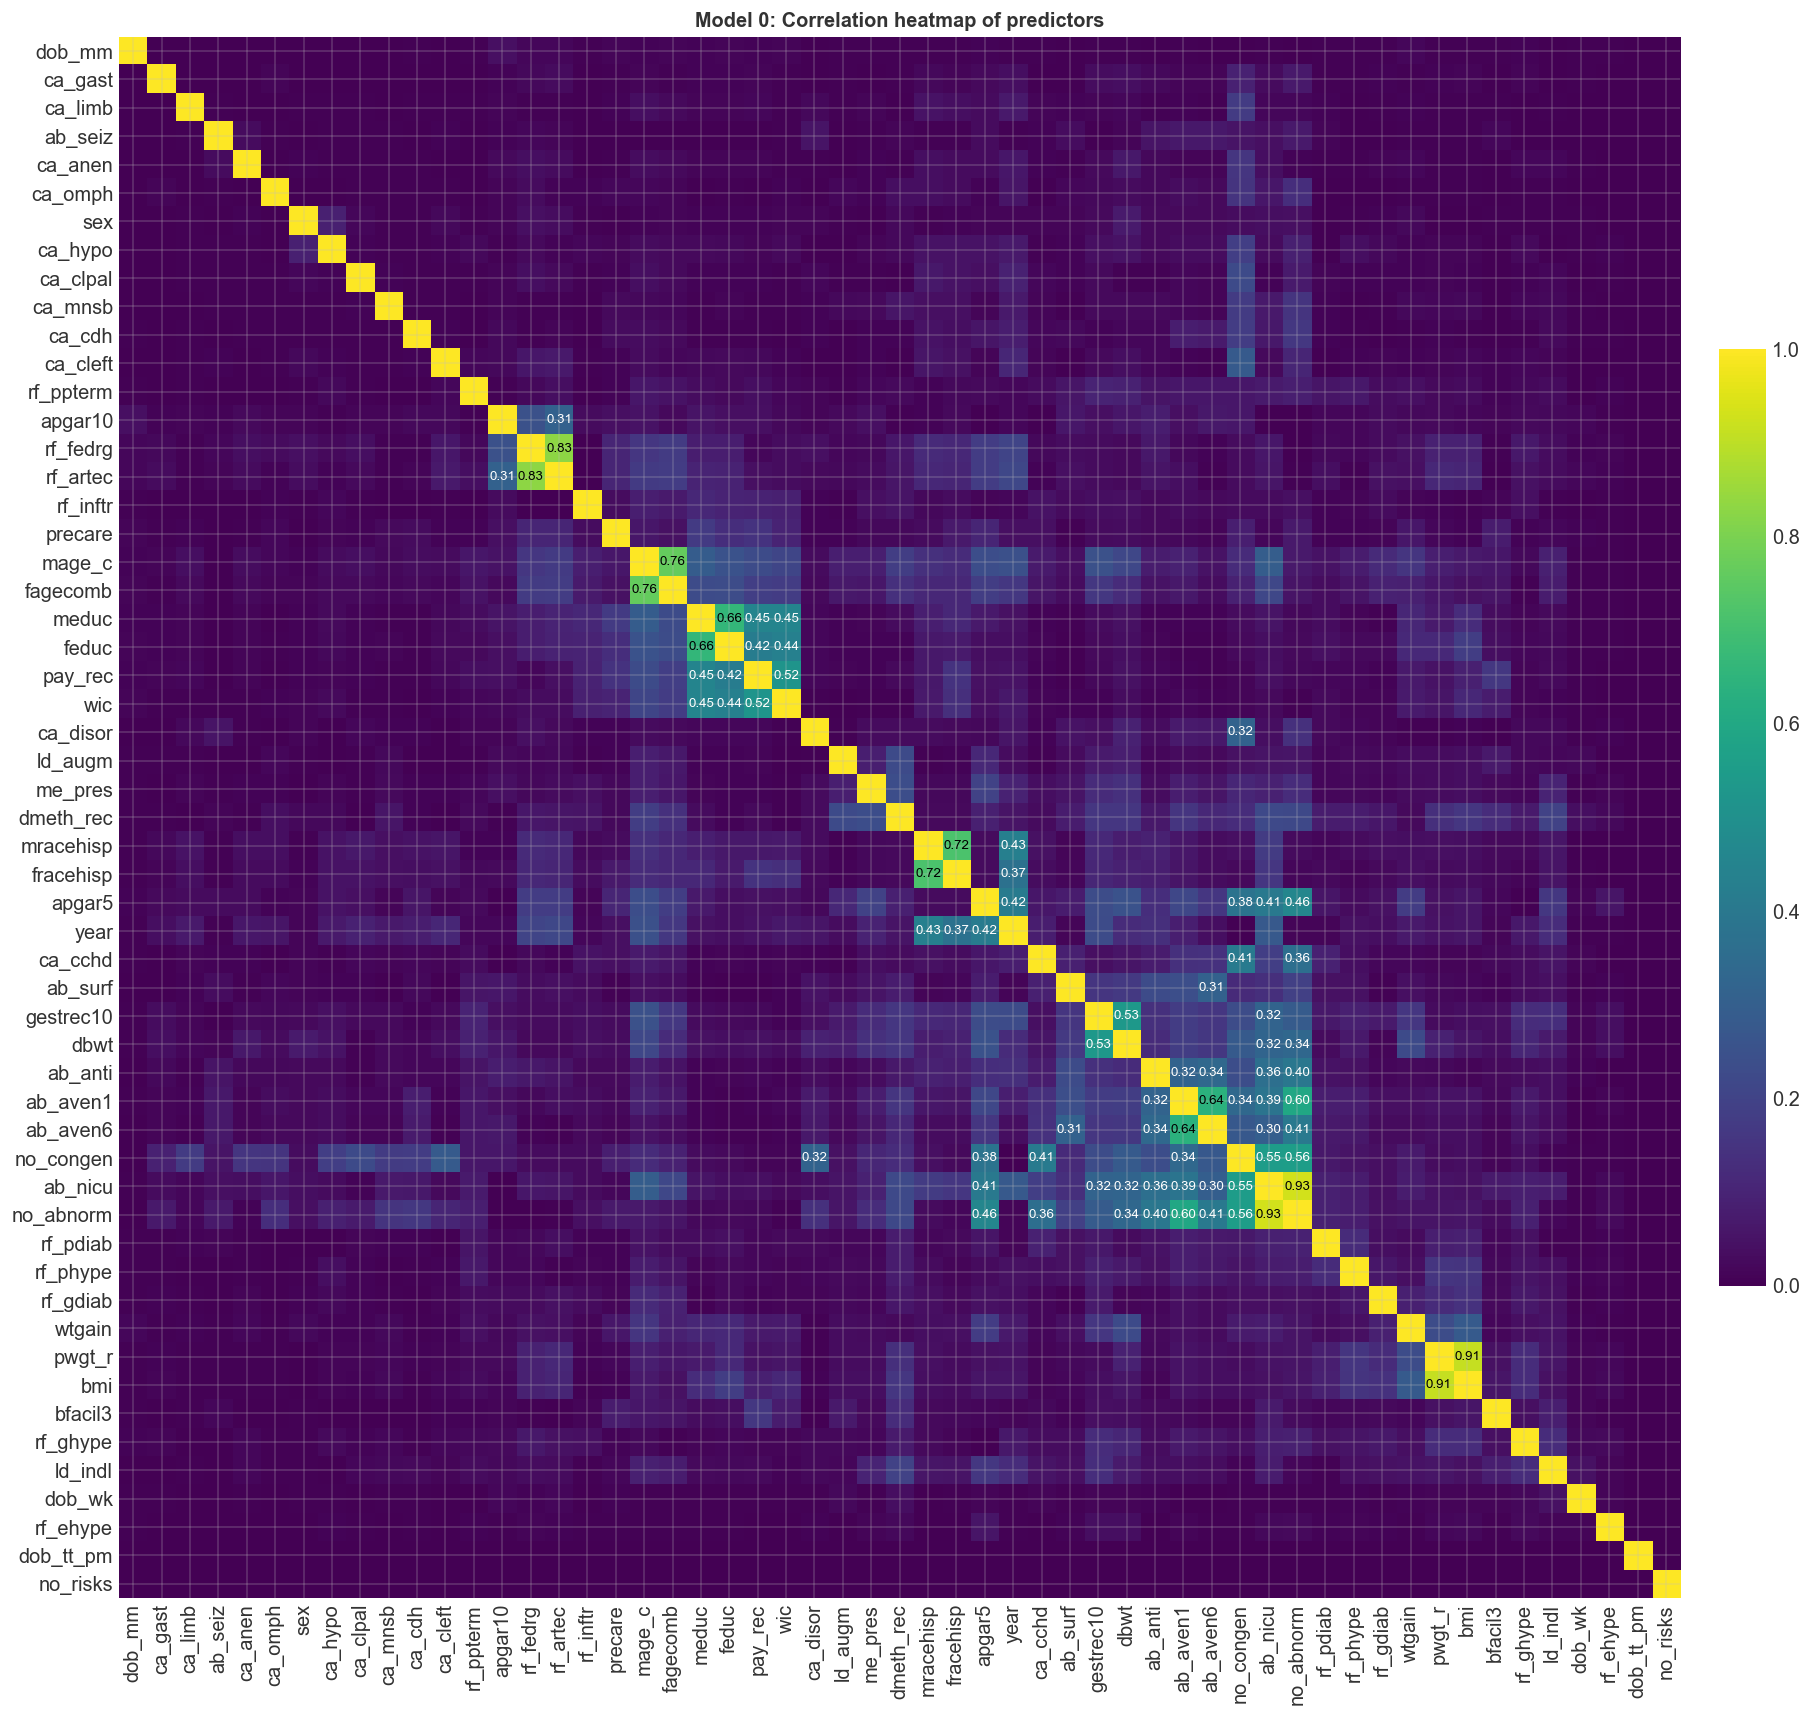

In [20]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [21]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
41,no_congen,3.652416
53,mage_c,0.579743
25,ab_nicu,0.487061
49,dbwt,0.274588
6,gestrec10,0.221791
32,ca_cchd,0.152020
40,ca_disor,0.148413
7,rf_pdiab,0.148280
43,mracehisp,0.081178
37,ca_cleft,0.080820


In [22]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'gestrec10',
 'ca_cchd',
 'ca_disor',
 'rf_pdiab',
 'mracehisp',
 'ca_cleft',
 'rf_ghype',
 'ca_hypo',
 'ab_aven1',
 'wtgain',
 'no_abnorm',
 'ca_clpal',
 'ab_anti',
 'ca_limb',
 'year',
 'fracehisp',
 'ca_mnsb',
 'precare',
 'fagecomb',
 'ca_omph',
 'ca_gast',
 'ca_cdh',
 'rf_ehype',
 'ca_anen',
 'dmeth_rec',
 'pwgt_r',
 'ab_aven6',
 'meduc',
 'dob_mm',
 'bfacil3',
 'apgar5',
 'bmi',
 'ld_indl',
 'dob_wk',
 'rf_gdiab',
 'me_pres',
 'pay_rec',
 'feduc',
 'rf_phype',
 'sex',
 'ab_surf',
 'ld_augm',
 'rf_inftr',
 'rf_artec',
 'wic',
 'ab_seiz',
 'rf_ppterm',
 'no_risks',
 'rf_fedrg',
 'apgar10',
 'dob_tt_pm']

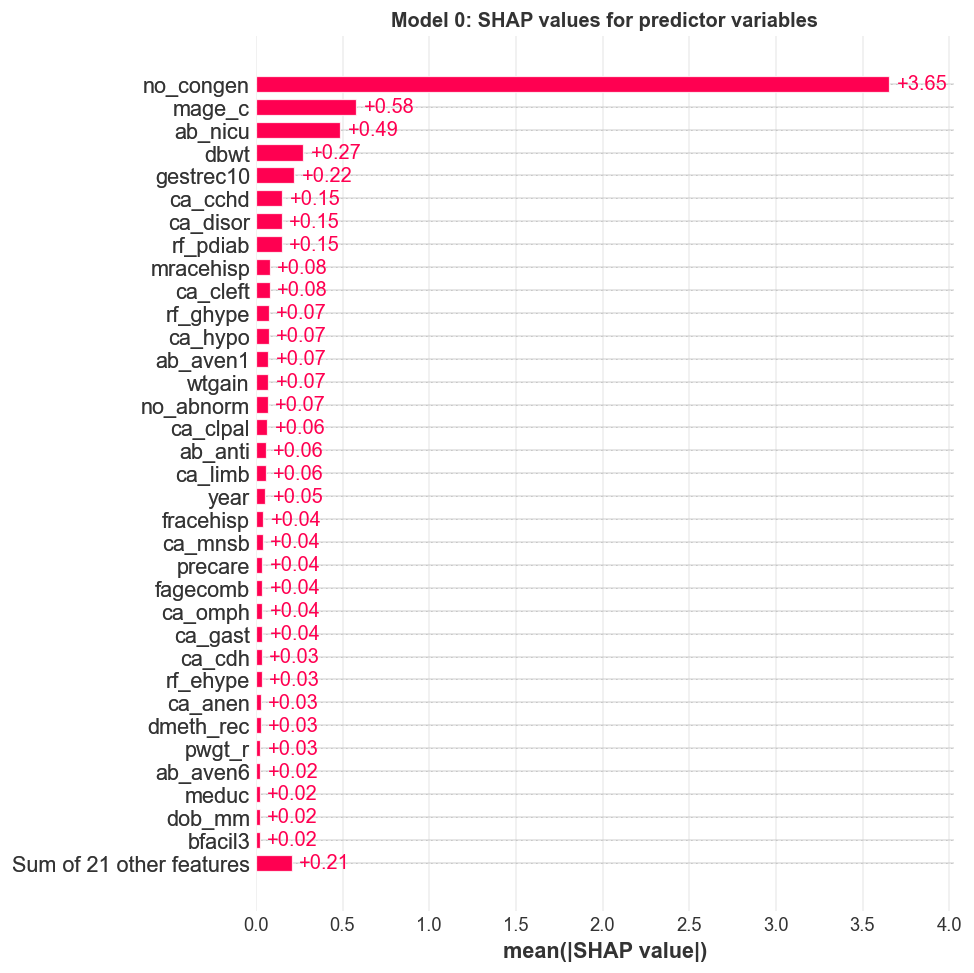

<Figure size 492x348 with 0 Axes>

In [23]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

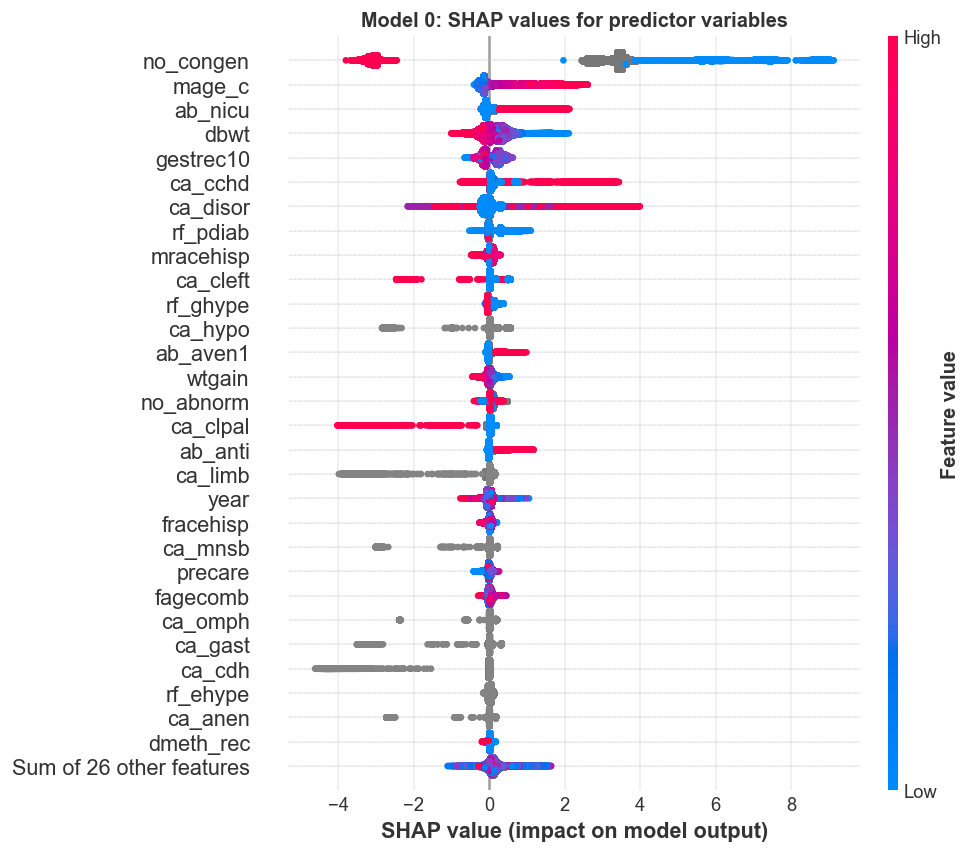

<Figure size 492x348 with 0 Axes>

In [24]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

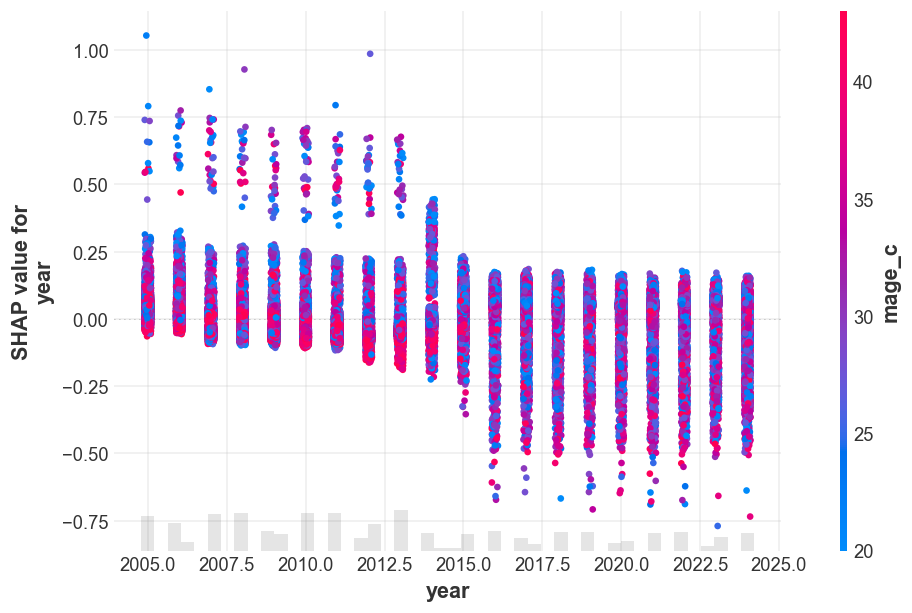

<Figure size 492x348 with 0 Axes>

In [27]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [ ]:
features_to_remove_0 = [
    "fagecomb",  # low SHAP value, correlated with mage_c
    "rf_gdiab",  # low SHAP value, low permutation importance
    "rf_phype",  # low SHAP value, low permutation importance
    "ab_aven6",  # low SHAP value, low permutation importance, correlated with ab_aven1
    # "meduc",  # low SHAP value, low permutation importance
    # "ca_anen",  # low SHAP value
    "pwgt_r",  # low SHAP value, correlated with bmi
    "dob_mm",  # low SHAP value, low permutation importance
    # "bmi",  # low SHAP value
    # "dob_wk",  # low SHAP value, low permutation importance
    "ld_indl",  # low SHAP value
    "me_pres",  # low SHAP value
    "sex",  # low SHAP value, low permutation importance
    "ab_seiz",  # low SHAP value, low permutation importance
    "feduc",  # low SHAP value, low permutation importance, correlated with meduc
    "ld_augm",  # low SHAP value, low permutation importance
    # "pay_rec",  # low SHAP value, low permutation importance
    "rf_inftr",  # low SHAP value, low permutation importance
    "no_risks",  # low SHAP value, low permutation importance
    "rf_artec",  # low SHAP value, low permutation importance
    "ab_surf",  # low SHAP value, low permutation importance
    "wic",  # low SHAP value, low permutation importance, correlated with pay_rec
    "rf_fedrg",  # low SHAP value, low permutation importance
    "rf_ppterm",  # low SHAP value, low permutation importance
    "apgar10",  # low SHAP value, low permutation importance
    "dob_tt_pm",  # low SHAP value, low permutation importance
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['fagecomb', 'rf_gdiab', 'rf_phype', 'ab_aven6', 'ca_anen', 'pwgt_r', 'dob_mm', 'ld_indl', 'me_pres', 'sex', 'ab_seiz', 'feduc', 'ld_augm', 'rf_inftr', 'no_risks', 'rf_artec', 'ab_surf', 'wic', 'rf_fedrg', 'rf_ppterm', 'apgar10', 'dob_tt_pm']
Features remaining: ['dob_wk', 'bfacil3', 'precare', 'gestrec10', 'rf_pdiab', 'rf_ghype', 'rf_ehype', 'dmeth_rec', 'apgar5', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'meduc', 'mracehisp', 'fracehisp', 'pay_rec', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c']
Number of features in Model 1 (after removing 22 predictors): 33


In [29]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[10]	train's average_precision: 0.512244	train's binary_logloss: 0.00278516	valid's average_precision: 0.505602	valid's binary_logloss: 0.00279946
[20]	train's average_precision: 0.516038	train's binary_logloss: 0.00264912	valid's average_precision: 0.509219	valid's binary_logloss: 0.00266811
[30]	train's average_precision: 0.517923	train's binary_logloss: 0.00253365	valid's average_precision: 0.510693	valid's binary_logloss: 0.00255606
[40]	train's average_precision: 0.518726	train's binary_logloss: 0.00243702	valid's average_precision: 0.511185	valid's binary_logloss: 0.00246252
[50]	train's a

In [30]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [31]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.966610
1,Validation AP,0.530275
2,Validation log loss,0.001924
3,Precision at 10000,0.521900
4,Recall at 10000,0.525367
5,Precision (threshold=0.01),0.116169
6,Recall (threshold=0.01),0.621401


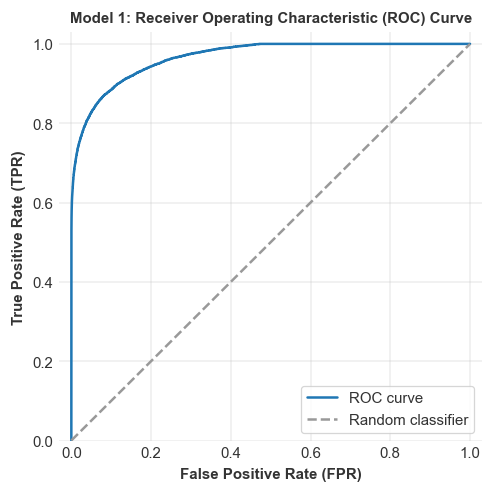

In [32]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

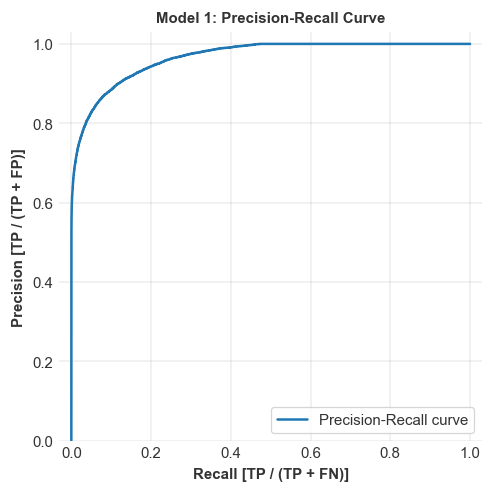

In [33]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [34]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
23,no_congen,3.191930e+06
19,ca_cleft,3.907395e+05
32,mage_c,3.693773e+05
21,ca_hypo,3.390718e+05
22,ca_disor,2.547967e+05
14,ca_cchd,2.518745e+05
10,ab_nicu,2.396522e+05
20,ca_clpal,1.667063e+05
29,dbwt,1.467463e+05
17,ca_gast,1.374074e+05


In [35]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=5,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
23,no_congen,0.474552,0.001757
14,ca_cchd,0.200031,0.000596
19,ca_cleft,0.155953,0.001548
22,ca_disor,0.150079,0.001281
21,ca_hypo,0.139182,0.001631
20,ca_clpal,0.115683,0.001590
15,ca_cdh,0.109855,0.001751
18,ca_limb,0.083208,0.001257
13,ca_mnsb,0.077740,0.001083
16,ca_omph,0.063064,0.000935


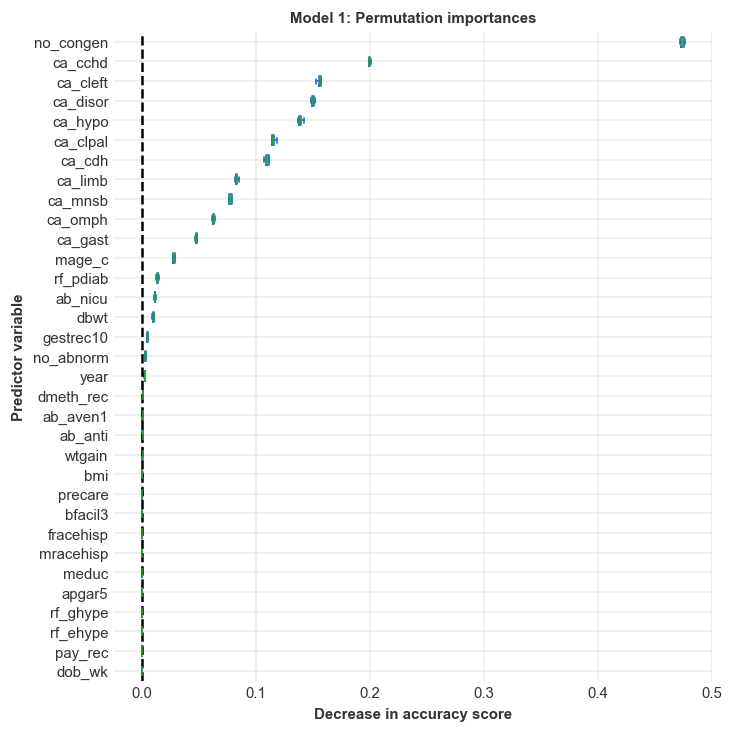

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

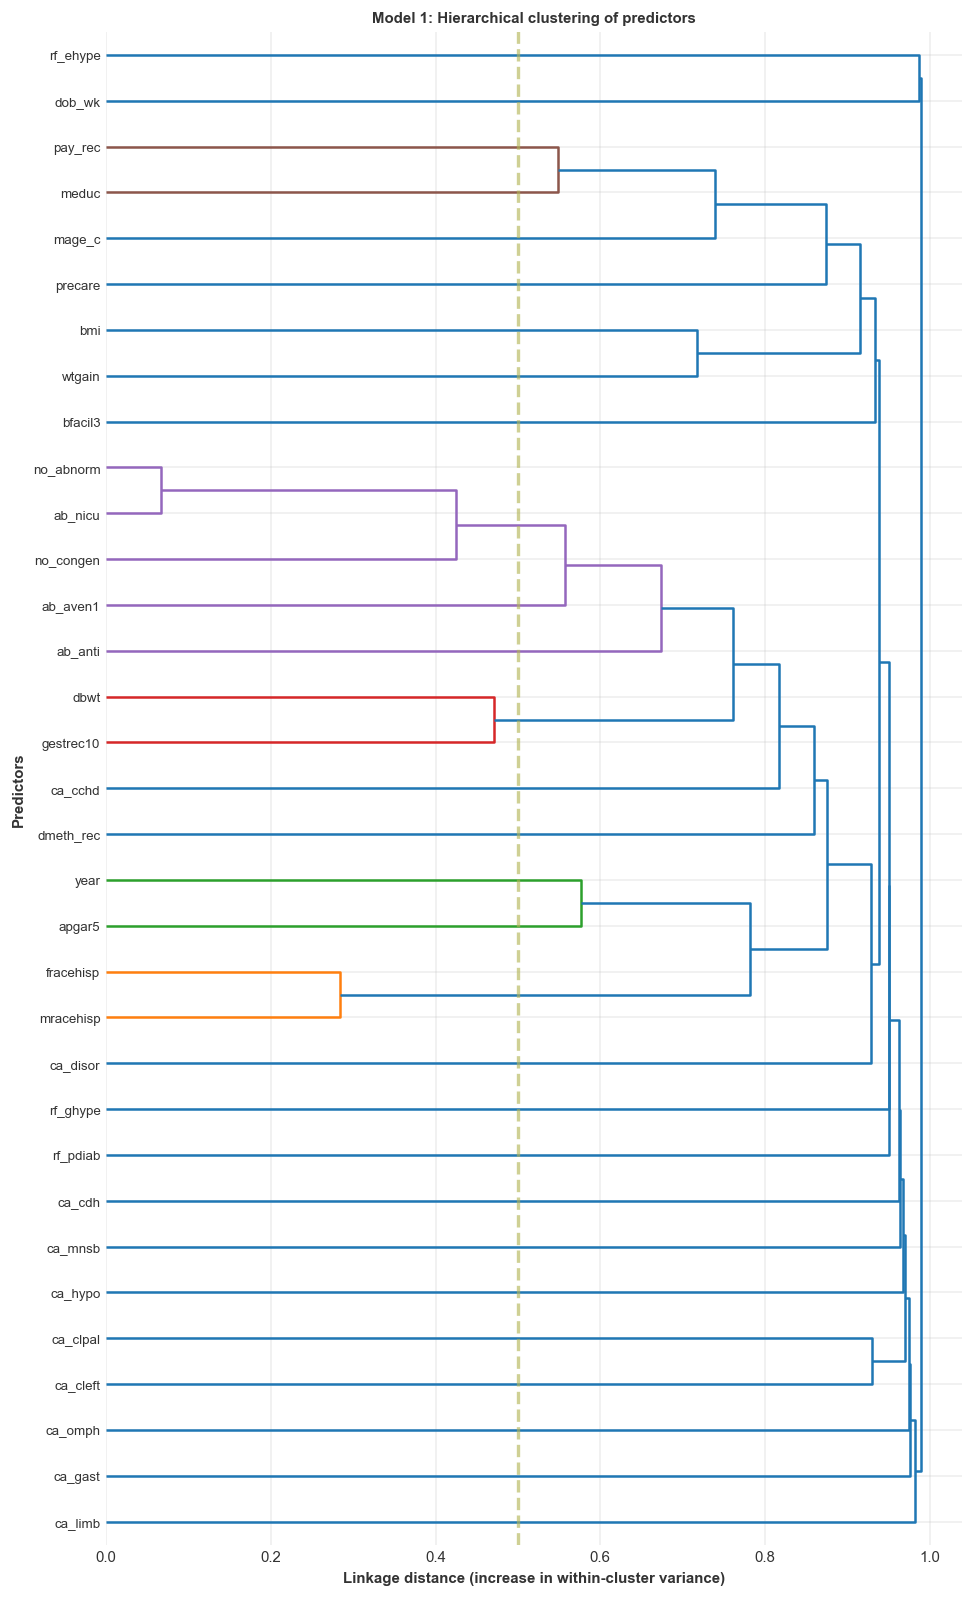

In [38]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

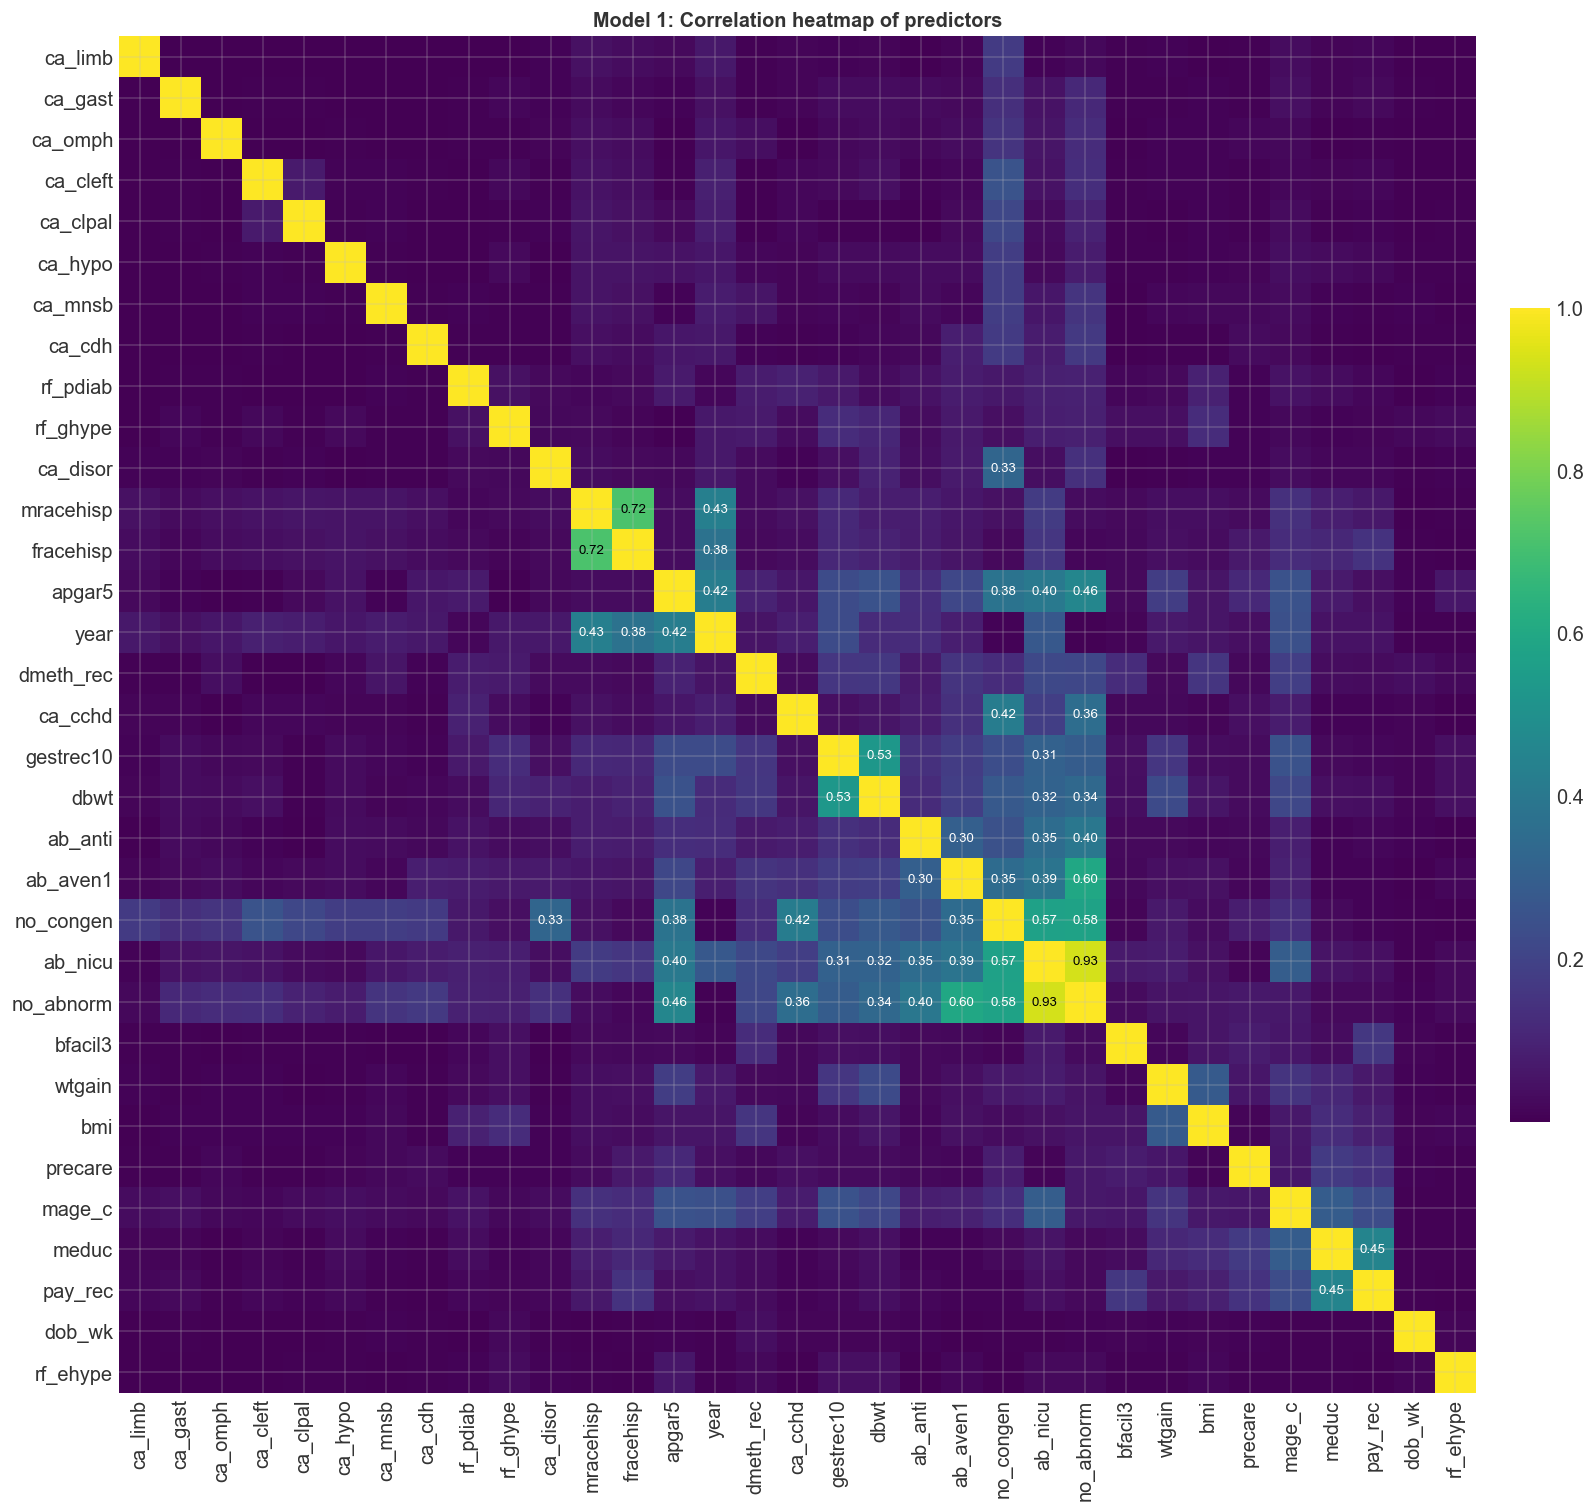

In [39]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [40]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
23,no_congen,3.586435
32,mage_c,0.644717
10,ab_nicu,0.553004
29,dbwt,0.273110
3,gestrec10,0.260718
4,rf_pdiab,0.135468
14,ca_cchd,0.111340
25,mracehisp,0.088607
9,ab_aven1,0.086632
22,ca_disor,0.081233


In [41]:
shap_importance["feature"].tolist()

['no_congen',
 'mage_c',
 'ab_nicu',
 'dbwt',
 'gestrec10',
 'rf_pdiab',
 'ca_cchd',
 'mracehisp',
 'ab_aven1',
 'ca_disor',
 'ca_cleft',
 'ab_anti',
 'wtgain',
 'ca_hypo',
 'no_abnorm',
 'year',
 'fracehisp',
 'ca_clpal',
 'precare',
 'bmi',
 'meduc',
 'ca_cdh',
 'ca_mnsb',
 'ca_limb',
 'dob_wk',
 'ca_gast',
 'dmeth_rec',
 'bfacil3',
 'rf_ghype',
 'ca_omph',
 'pay_rec',
 'apgar5',
 'rf_ehype']

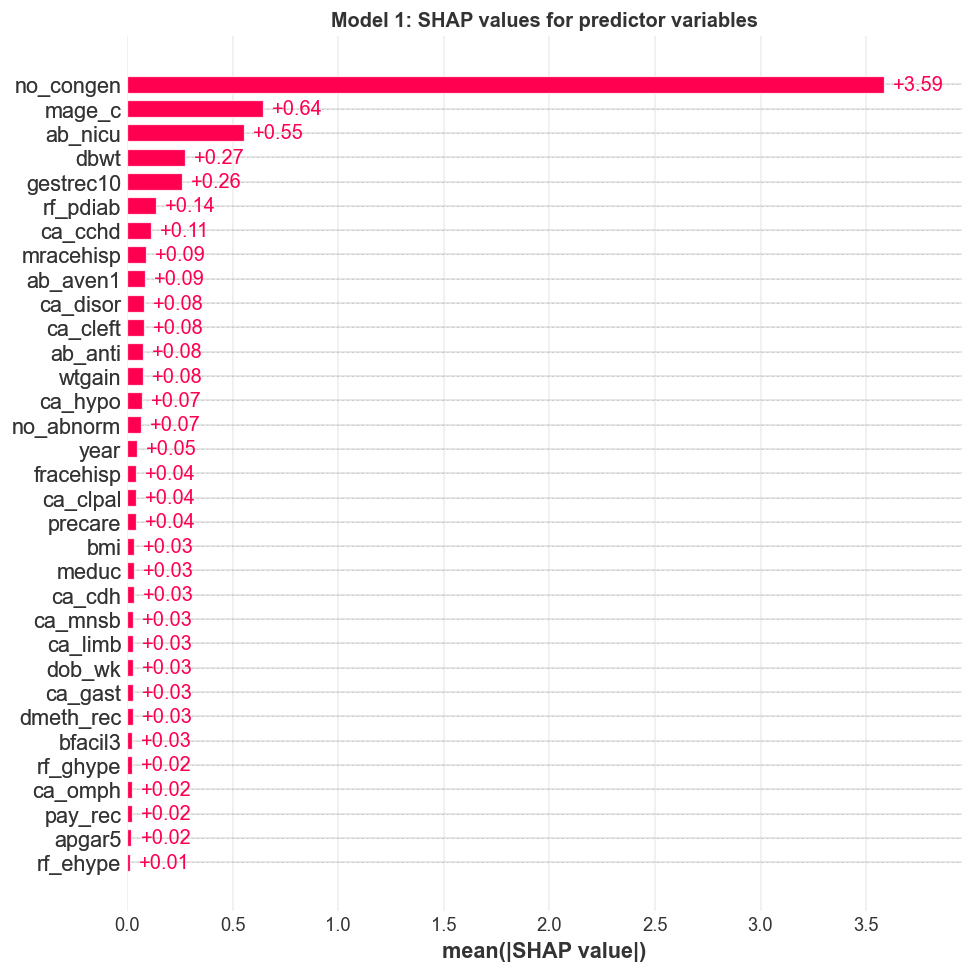

<Figure size 492x348 with 0 Axes>

In [42]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

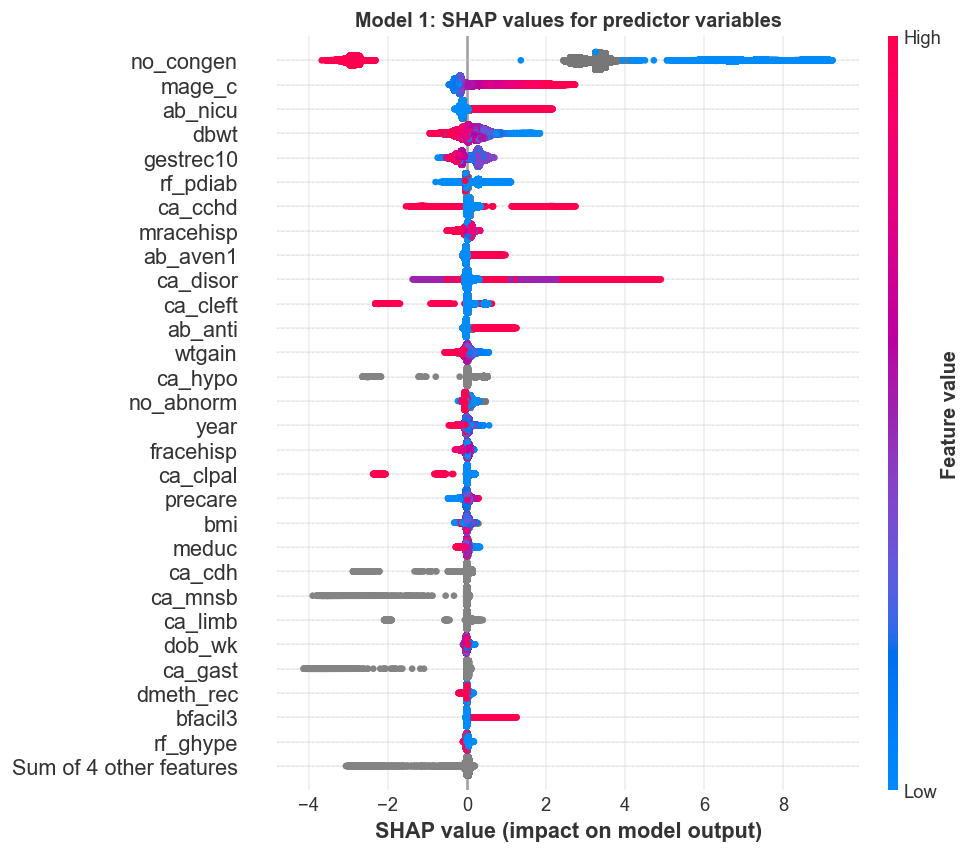

<Figure size 492x348 with 0 Axes>

In [43]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

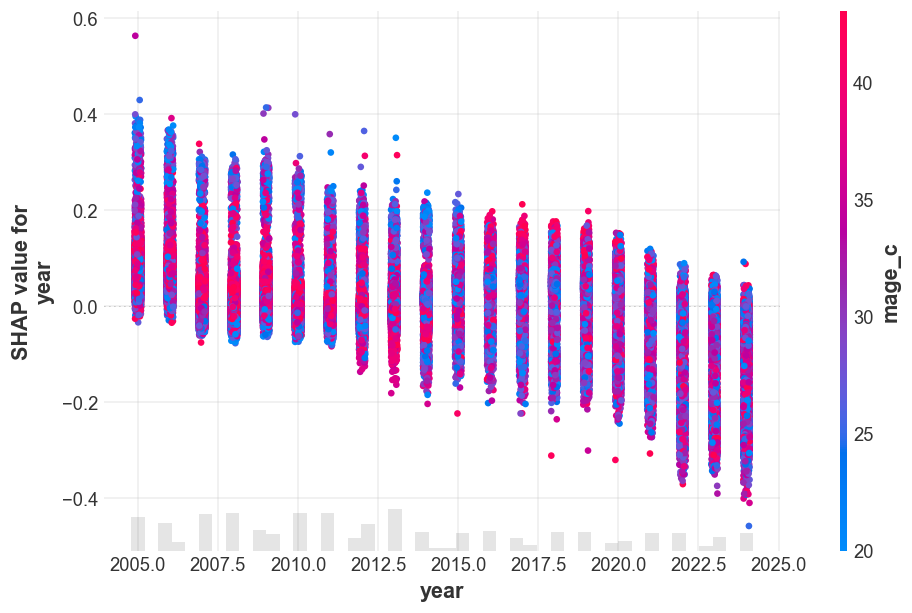

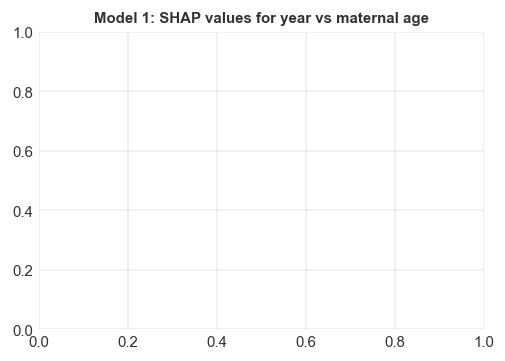

In [44]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [ ]:
features_to_remove_1 = [
    "wtgain",  # correlated with bmi
    "fracehisp",  # low SHAP value, correlated with mracehisp
    "bmi",  # low SHAP value
    "meduc",  # low SHAP value
    "dob_wk",  # low SHAP value
    "dmeth_rec",  # low SHAP value
    "bfacil3",  # low SHAP value
    "rf_ghype",  # low SHAP value
    "ca_omph",  # low SHAP value
    "pay_rec",  # low SHAP value
    "apgar5",  # low SHAP value
    "rf_ehype",  # low SHAP value
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['wtgain', 'fracehisp', 'bmi', 'meduc', 'dob_wk', 'dmeth_rec', 'bfacil3', 'rf_ghype', 'ca_omph', 'pay_rec', 'apgar5', 'rf_ehype']
Features remaining: ['precare', 'gestrec10', 'rf_pdiab', 'ab_aven1', 'ab_nicu', 'ab_anti', 'no_abnorm', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'no_congen', 'mracehisp', 'year', 'dbwt', 'mage_c']
Number of features in Model 2 (after removing 12 predictors): 21


In [64]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 19869, number of negative: 39061040
[LightGBM] [Info] Total Bins 395
[LightGBM] [Info] Number of data points in the train set: 39080909, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000508 -> initscore=-7.583720
[LightGBM] [Info] Start training from score -7.583720
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's average_precision: 0.468818	train's binary_logloss: 0.00271696	valid's average_precision: 0.457877	valid's binary_logloss: 0.00273292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	train's average_precision: 0.470746	train's binary_logloss: 0.00259721	valid's average_precision: 0.461466	valid's binary_logloss: 0.00261591
[LightGB

In [65]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [67]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.963472
1,Validation AP,0.465734
2,Validation log loss,0.002549
3,Precision at 10000,0.497000
4,Recall at 10000,0.500302
5,Precision (threshold=0.01),0.311232
6,Recall (threshold=0.01),0.534427


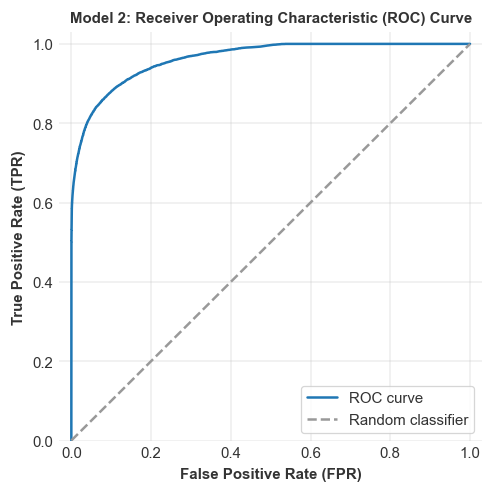

In [68]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

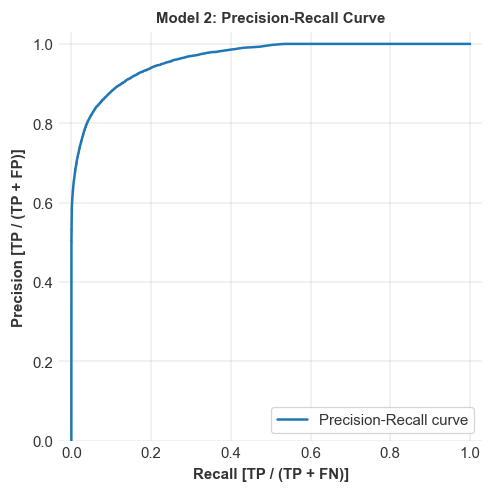

In [69]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [70]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
16,no_congen,2.534822e+06
8,ca_cchd,4.656850e+05
12,ca_cleft,3.845119e+05
14,ca_hypo,3.325458e+05
13,ca_clpal,2.315235e+05
7,ca_mnsb,1.929470e+05
9,ca_cdh,1.868000e+05
20,mage_c,1.219245e+05
15,ca_disor,9.040603e+04
4,ab_nicu,6.533359e+04


In [71]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=5,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
16,no_congen,0.439855,0.000256
8,ca_cchd,0.180718,0.001539
15,ca_disor,0.105538,0.001090
6,no_abnorm,0.091510,0.000876
4,ab_nicu,0.073935,0.003010
10,ca_gast,0.058488,0.001194
20,mage_c,0.046270,0.001835
7,ca_mnsb,0.037281,0.002055
14,ca_hypo,0.036971,0.002019
9,ca_cdh,0.036634,0.001756


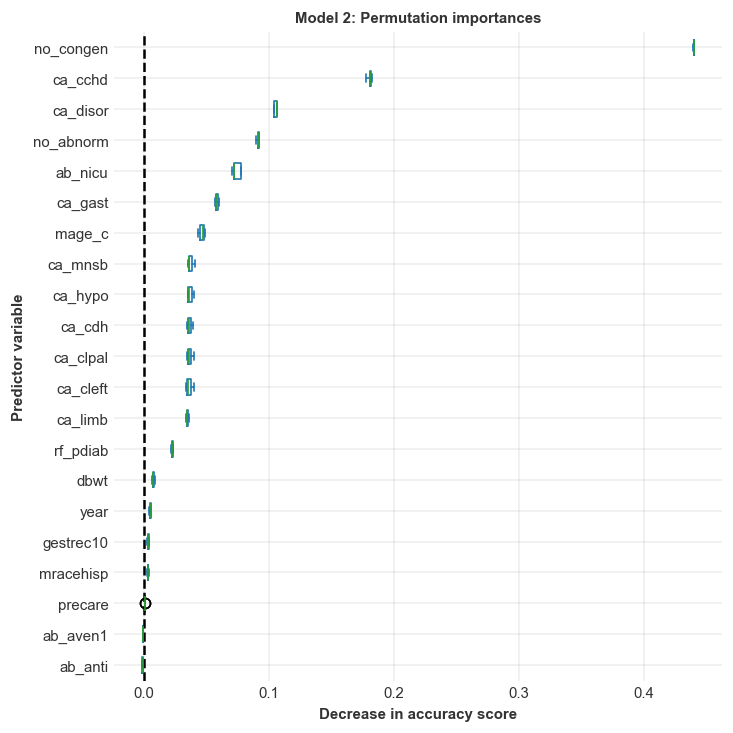

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

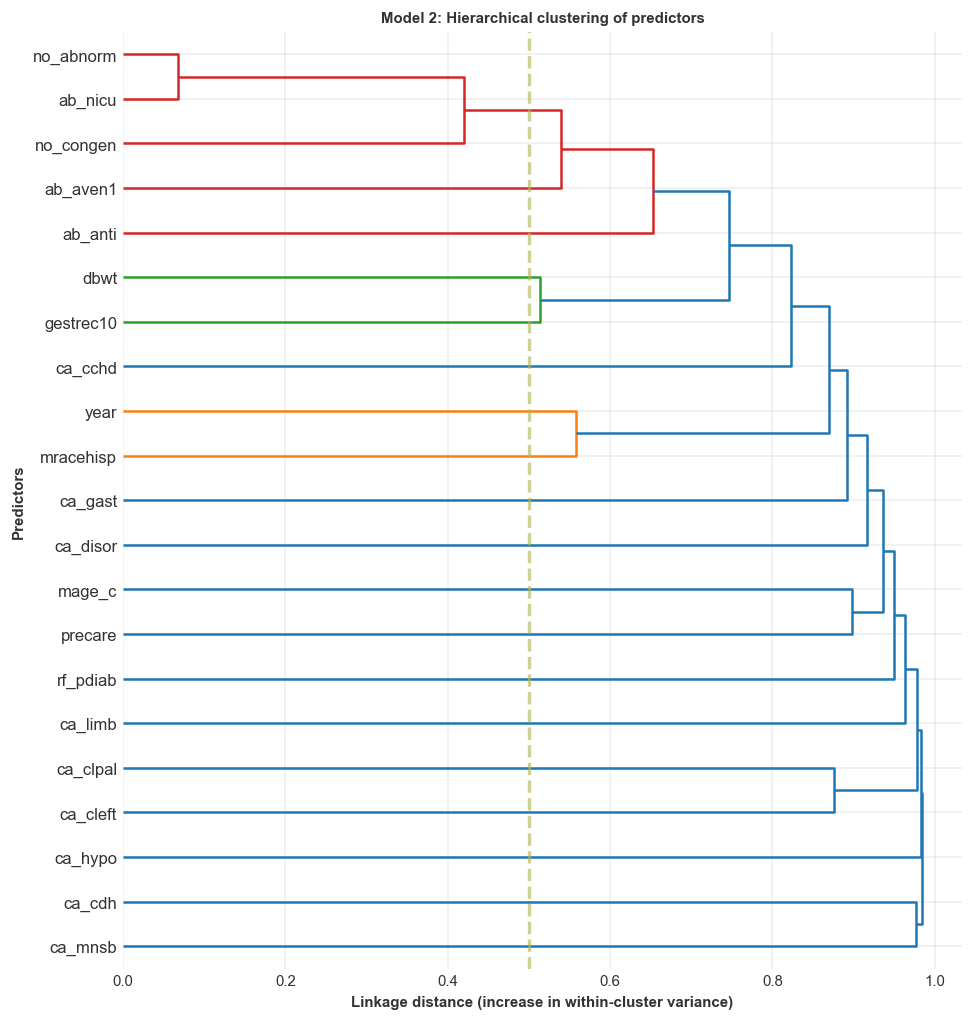

In [74]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

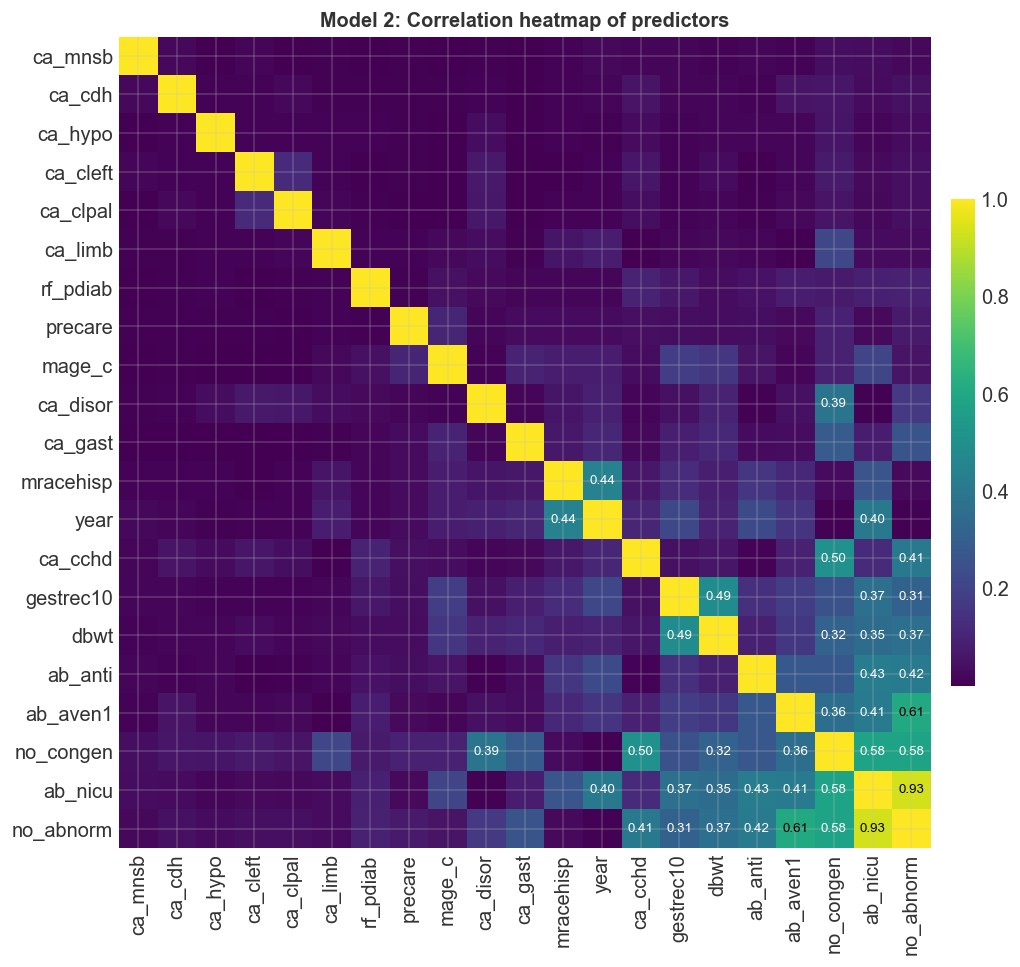

In [75]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [76]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\miniconda3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
c:\Users\FrankBuckley\

,feature,mean_abs_shap
16,no_congen,0.556201
4,ab_nicu,0.239372
8,ca_cchd,0.098155
20,mage_c,0.085931
19,dbwt,0.065130
6,no_abnorm,0.055734
1,gestrec10,0.053201
5,ab_anti,0.039053
12,ca_cleft,0.035395
14,ca_hypo,0.034631


In [77]:
shap_importance["feature"].tolist()

['no_congen',
 'ab_nicu',
 'ca_cchd',
 'mage_c',
 'dbwt',
 'no_abnorm',
 'gestrec10',
 'ab_anti',
 'ca_cleft',
 'ca_hypo',
 'ab_aven1',
 'ca_clpal',
 'ca_disor',
 'rf_pdiab',
 'mracehisp',
 'ca_cdh',
 'ca_mnsb',
 'ca_gast',
 'ca_limb',
 'year',
 'precare']

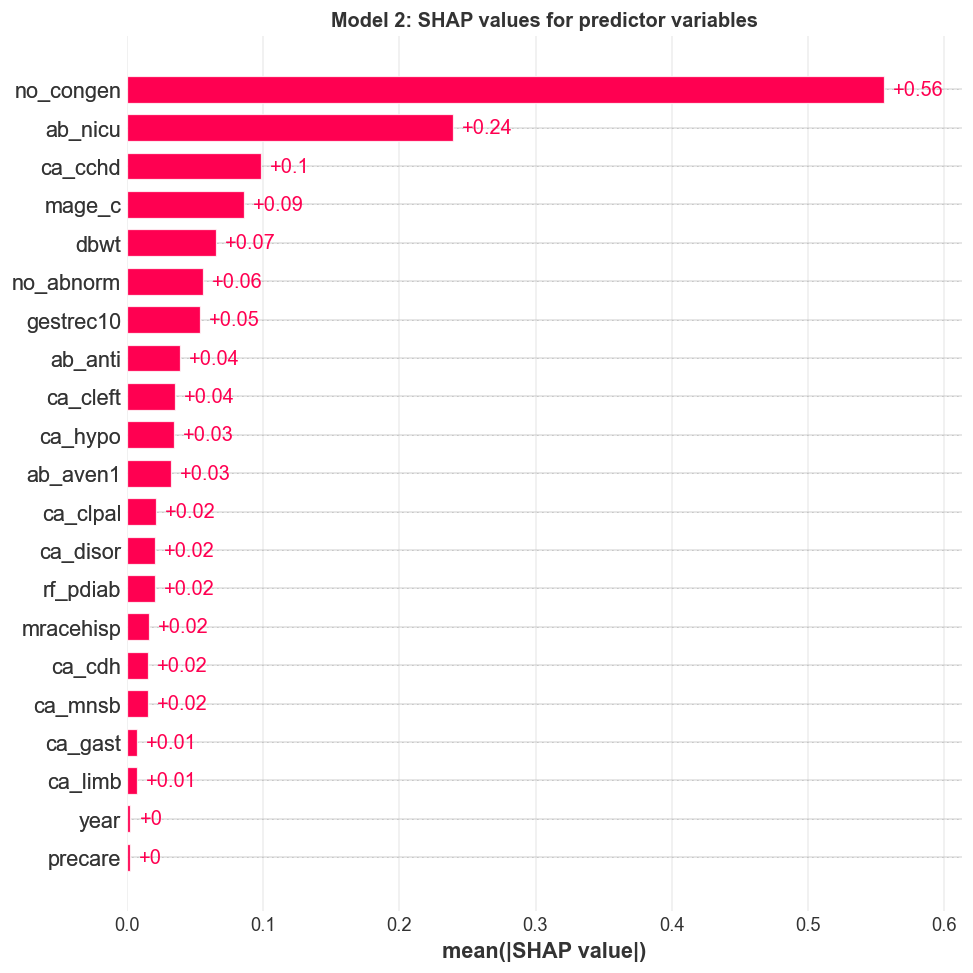

<Figure size 492x348 with 0 Axes>

In [78]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

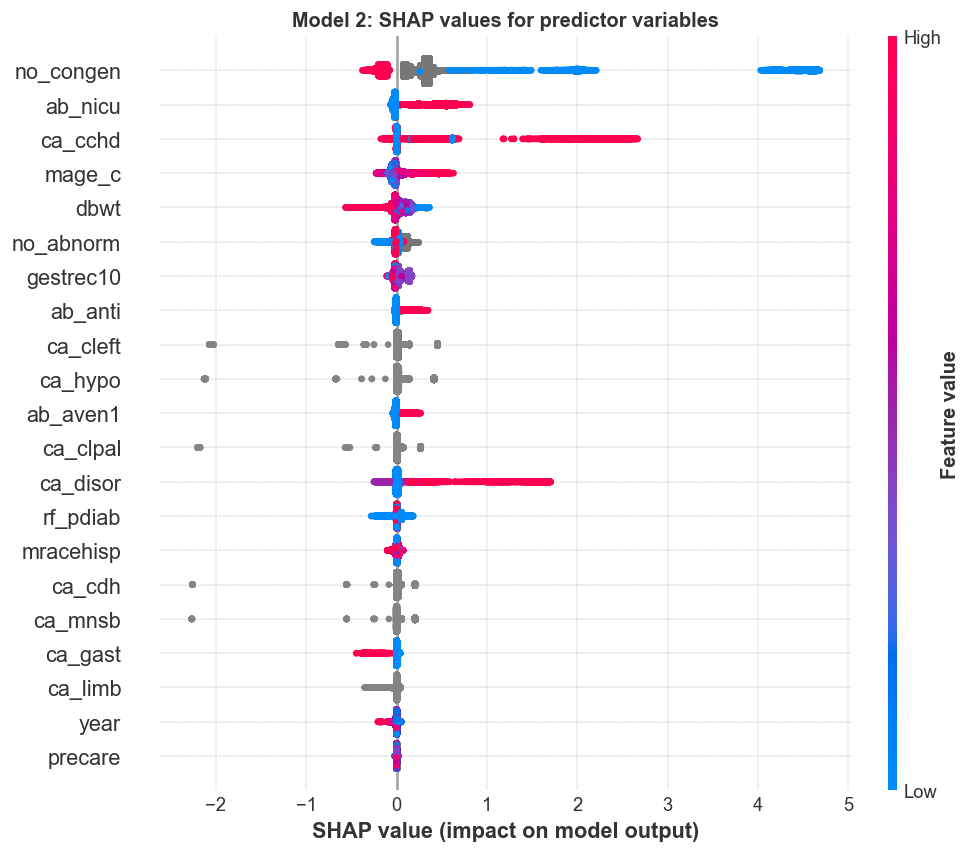

<Figure size 492x348 with 0 Axes>

In [79]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

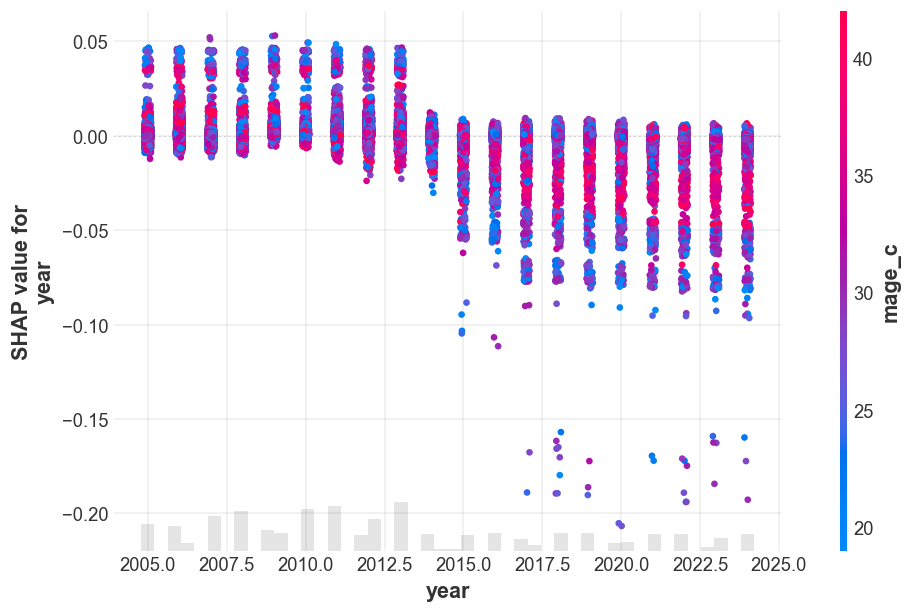

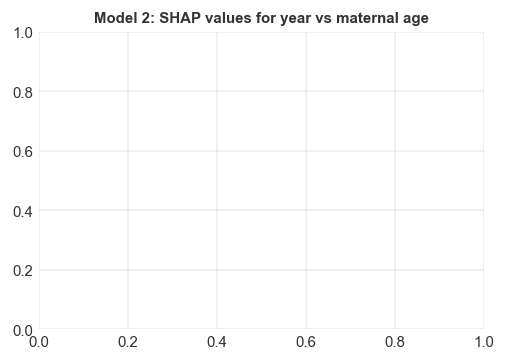

In [80]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 3


## Calibration


In [81]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

ValueError: train and valid dataset categorical_feature do not match.

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)
p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))